**Deep Learning: Recurrent Neural Networks & Transformer**

---
In this project, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.

In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

**Exercise 4.1: Simple RNN**

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import torch


np.random.seed(42)

Load dataset:

In this project we used the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

 In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


The right activation function to insert in the output layer is sigmoidal, because the activity we want to perform is a binary classification. That activation function gives a value between 0 and 1. So, given an input, the sigmoidal function indicates whether that example belongs to a specific class or not. The sigmoidal function doesn't just return two possible values (0 and 1). It is a function that returns a value in the range (0,1) and is differentiable and continuous.

The loss function that fits the task we want to perform is the binary cross-entropy. The task of this exercise is to recognize if a given input belongs to a class or to another class, so the task is a binary classification. The labels of the two classes can be expressed in a binary way, such as, 0 and 1 or A and B.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 92s 447ms/step - loss: 0.6757 - accuracy: 0.5742 - val_loss: 0.7146 - val_accuracy: 0.5309
Epoch 2/10
196/196 [==============================] - 86s 439ms/step - loss: 0.4621 - accuracy: 0.7915 - val_loss: 0.3894 - val_accuracy: 0.8311
Epoch 3/10
196/196 [==============================] - 86s 441ms/step - loss: 0.3147 - accuracy: 0.8718 - val_loss: 0.3739 - val_accuracy: 0.8396
Epoch 4/10
196/196 [==============================] - 88s 447ms/step - loss: 0.2237 - accuracy: 0.9143 - val_loss: 0.3874 - val_accuracy: 0.8511
Epoch 5/10
196/196 [==============================] - 86s 438ms/step - loss: 0.1752 - accuracy: 0.9363 - val_loss: 0.4193 - val_accuracy: 0.8286
Epoch 6/10
196/196 [==============================] - 85s 434ms/step - loss: 0.3107 - accuracy: 0.8682 - val_loss: 0.6387 - val_accuracy: 0.6298
Epoch 7/10
196/196 [==============================] - 86s 440ms/step - loss: 0.2813 - accuracy: 0.8822 - val_loss: 0.4448 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 13s - loss: 0.5096 - accuracy: 0.8370 - 13s/epoch - 33ms/step
accuracy: 83.70%


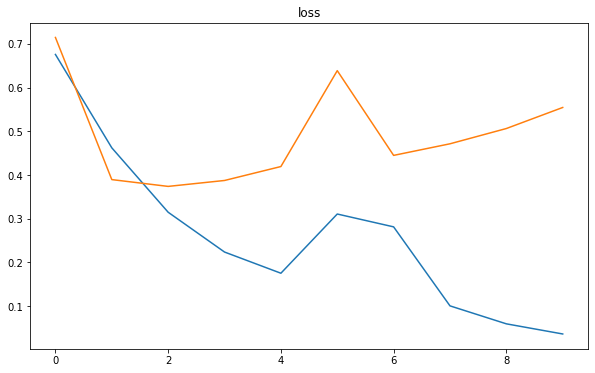

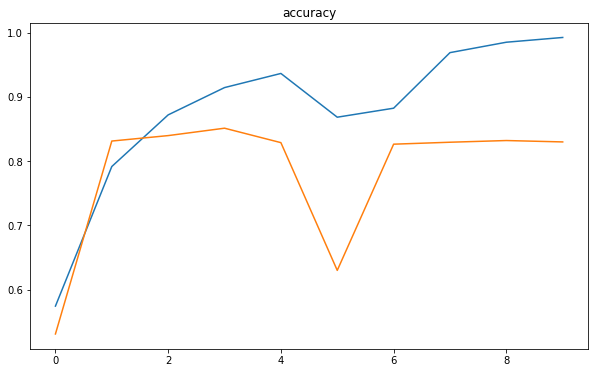

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
We will implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, we are gonna discuss the differences in terms of performance, the number of parameters, and training time.

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 14)                1400      
                                                                 
 dense_1 (Dense)             (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


Epoch 1/10
196/196 [==============================] - 54s 260ms/step - loss: 0.5279 - accuracy: 0.7540 - val_loss: 0.3857 - val_accuracy: 0.8430
Epoch 2/10
196/196 [==============================] - 51s 260ms/step - loss: 0.3061 - accuracy: 0.8841 - val_loss: 0.3255 - val_accuracy: 0.8663
Epoch 3/10
196/196 [==============================] - 50s 258ms/step - loss: 0.2274 - accuracy: 0.9202 - val_loss: 0.3129 - val_accuracy: 0.8706
Epoch 4/10
196/196 [==============================] - 51s 262ms/step - loss: 0.1826 - accuracy: 0.9374 - val_loss: 0.3359 - val_accuracy: 0.8650
Epoch 5/10
196/196 [==============================] - 52s 264ms/step - loss: 0.1570 - accuracy: 0.9492 - val_loss: 0.3553 - val_accuracy: 0.8675
Epoch 6/10
196/196 [==============================] - 52s 267ms/step - loss: 0.1287 - accuracy: 0.9598 - val_loss: 0.3530 - val_accuracy: 0.8682
Epoch 7/10
196/196 [==============================] - 52s 267ms/step - loss: 0.1107 - accuracy: 0.9671 - val_loss: 0.4262 - val_ac

391/391 - 12s - loss: 0.4331 - accuracy: 0.8613 - 12s/epoch - 29ms/step
accuracy: 86.13%


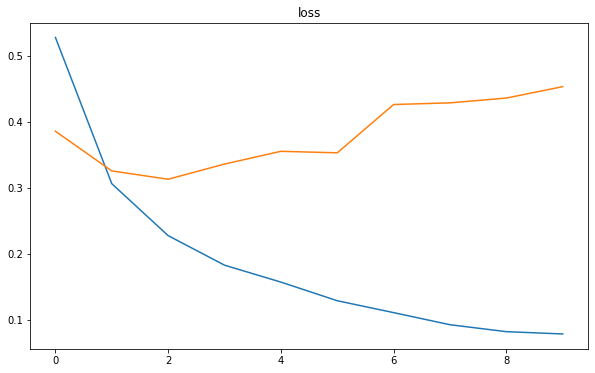

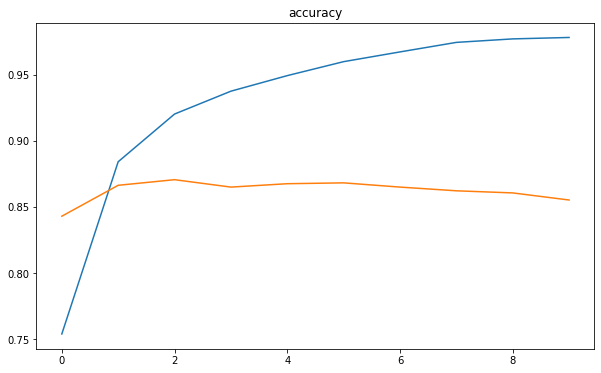

In [ ]:
plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(lossd='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 16)                1344      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


Epoch 1/10
196/196 [==============================] - 55s 267ms/step - loss: 0.5730 - accuracy: 0.6733 - val_loss: 0.4118 - val_accuracy: 0.8160
Epoch 2/10
196/196 [==============================] - 53s 269ms/step - loss: 0.3117 - accuracy: 0.8723 - val_loss: 0.3476 - val_accuracy: 0.8536
Epoch 3/10
196/196 [==============================] - 52s 267ms/step - loss: 0.2385 - accuracy: 0.9093 - val_loss: 0.3402 - val_accuracy: 0.8584
Epoch 4/10
196/196 [==============================] - 52s 263ms/step - loss: 0.1958 - accuracy: 0.9290 - val_loss: 0.3442 - val_accuracy: 0.8614
Epoch 5/10
196/196 [==============================] - 51s 259ms/step - loss: 0.1635 - accuracy: 0.9445 - val_loss: 0.3562 - val_accuracy: 0.8598
Epoch 6/10
196/196 [==============================] - 52s 263ms/step - loss: 0.1412 - accuracy: 0.9528 - val_loss: 0.3937 - val_accuracy: 0.8588
Epoch 7/10
196/196 [==============================] - 52s 266ms/step - loss: 0.1280 - accuracy: 0.9582 - val_loss: 0.4207 - val_ac

391/391 - 13s - loss: 0.4935 - accuracy: 0.8538 - 13s/epoch - 34ms/step
accuracy: 85.38%


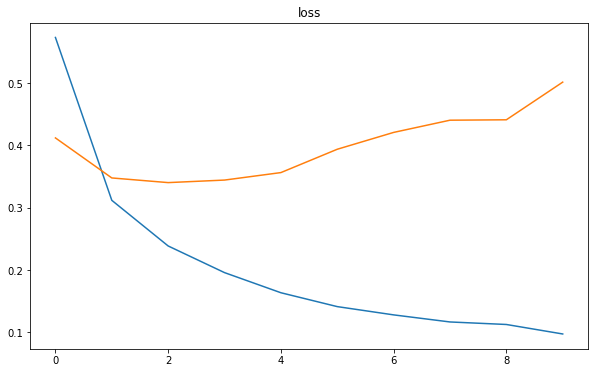

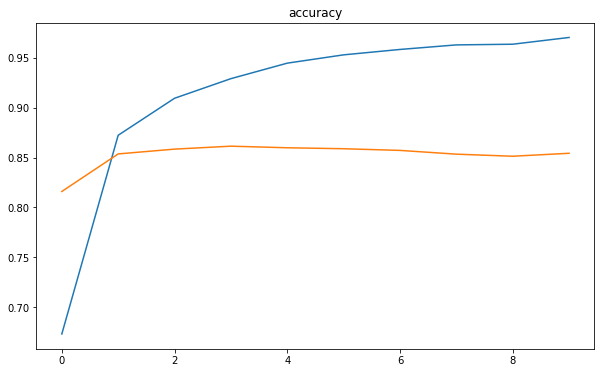

In [ ]:
plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

LSTM and GRU have achieved better accuracy and lower losses than SimpleRNN. The main reason is that LSTM and GRU are specific architectures designed to perform in this application field. In particular, these architectures are able to cope with the vanishing gradient problem, a common problem of RNNs.

If we focus on the results of LSTM and GRU, we can notice that LSTM performed (slightly) better than GRU. We have to remember that the LSTM architecture is a generalization of the GRU architecture. So the GRU architecture is "simpler" than the LSTM architecture and this fact can influence on the vanishing gradient problem: maybe, LSTM is able to cope better this kind of problem than GRU.

**Number of parameters and training time**

- SimpleRNN: 1376 (total parameters of the network: 101409);
- LSTM: 1400 (total parameters of the network: 101415);
- GRU: 1344 (total parameters of the network: 101361).

We can notice that the SimpleRNN is faster in the training phase than LSTM and GRU. This is a side effect of the complexity of the LSTM and GRU architectures. The time required by LSTM and GRU are roughly the same. We can notice that the time required by GRU is slightly smaller than LSTM because GRU has a simpler architecture than LSTM and, from this fact, GRU has a less number of parameters to be learnt than LSTM.

**Number of units** 

- SimpleRNN: 32;
- LSTM: 14;
- GRU: 16

To keep the same number of parameters of the SimpleRNN model, I found that the ideal number of units for LSTM is 14 and for GRU is 16. The reason that the GRU has more units than LSTM is that the GRU architecture has less parameters to be learnt. Less parameters may come at the cost of decreased expressibility. So, if LSTM and GRU have the same number of units, GRU will have a less number of parameters to be learnt than LSTM model.



### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 127s 621ms/step - loss: 0.6007 - accuracy: 0.6796 - val_loss: 0.4618 - val_accuracy: 0.7998
Epoch 2/5
196/196 [==============================] - 121s 615ms/step - loss: 0.3195 - accuracy: 0.868

391/391 - 22s - loss: 0.3443 - accuracy: 0.8773 - 22s/epoch - 56ms/step
accuracy: 87.73%


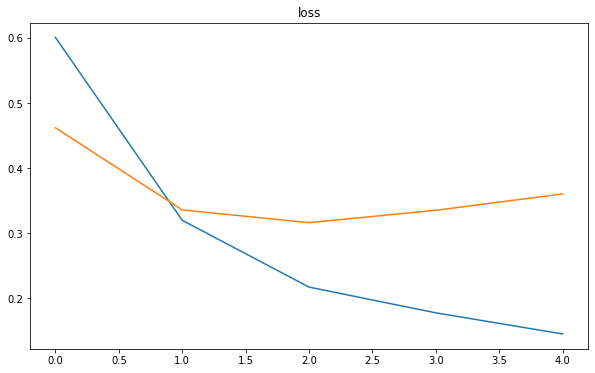

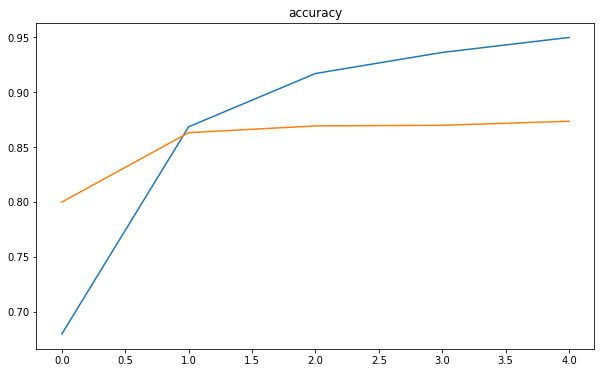

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. I will report the discussion in the cell at the end of the notebook.

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [ ]:
embed_dim = 512  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 8  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 90s 434ms/step - loss: 0.4816 - accuracy: 0.7378 - val_loss: 0.2986 - val_accuracy: 0.8708
Epoch 2/5
196/196 [==============================] - 85s 433ms/step - loss: 0.2328 - accuracy: 0.9107 - val_loss: 0.3184 - val_accuracy: 0.8648
Epoch 3/5
196/196 [==============================] - 85s 433ms/step - loss: 0.1735 - accuracy: 0.9339 - val_loss: 0.3603 - val_accuracy: 0.8620
Epoch 4/5
196/196 [==============================] - 85s 435ms/step - loss: 0.1338 - accuracy: 0.9499 - val_loss: 0.4732 - val_accuracy: 0.8461
Epoch 5/5
196/196 [==============================] - 85s 432ms/step - loss: 0.1071 - accuracy: 0.9581 - val_loss: 0.5448 - val_accuracy: 0.8522


391/391 - 15s - loss: 0.5316 - accuracy: 0.8506 - 15s/epoch - 38ms/step
accuracy: 85.06%


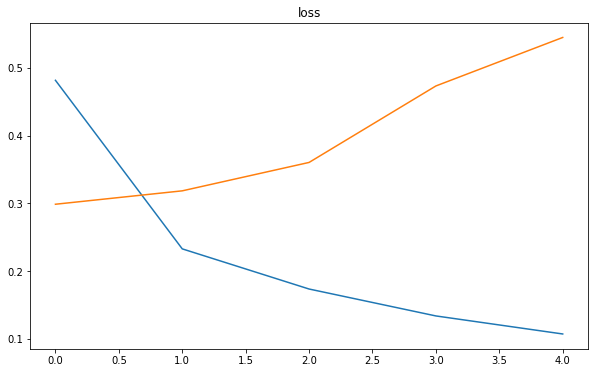

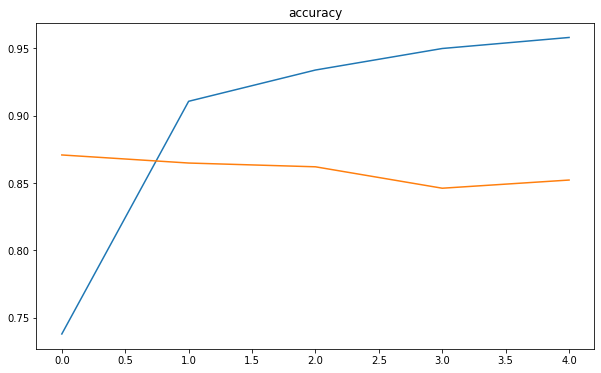

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

**DISCUSSION HERE:** 

Transformer stands out with parallel computation. In addition to performing parallel processing, a model that has more control over the content emerges at the end of the training, as it has a multi-head attention mechanism and evaluates the incoming data in 2 ways as left-to-right/right-to-left.

The key to the Transformer’s ground-breaking performance is its use of Attention.
While processing a word, Attention enables the model to focus on other words in the input that are closely related to that word.
The Transformer architecture uses self-attention by relating every word in the input sequence to every other word.

**How Attention Works**

The data gets split across the multiple Attention heads so that each can process it independently.

However, the important thing to understand is that this is a logical split only. The Query, Key, and Value are not physically split into separate matrices, one for each Attention head. A single data matrix is used for the Query, Key, and Value, respectively, with logically separate sections of the matrix for each Attention head. Similarly, there are not separate Linear layers, one for each Attention head. All the Attention heads share the same Linear layer but simply operate on their ‘own’ logical section of the data matrix.

***The best parameters I achieved is embed_dim = 512 , num_heads = 2 and ff_dim = 8. The accuracy is 85.06% and the CPU time is 15s.***


**THE PROBLEM WITH LSTMs**

The model often forgets the content of distant positions in the sequence. Another problem with RNNs, and LSTMs, is that it’s hard to parallelize the work for processing sentences, since you are have to process word by word. Not only that but there is no model of long and short range dependencies. To summarize, LSTMs and RNNs present 3 problems:

* Sequential computation inhibits parallelization
* No explicit modeling of long and short range dependencies
* “Distance” between positions is linear

**About Batch Size**

- Using a smaller batch size is like using some regularization effect and a lower generalization error. Generally, smaller batches lead to noisier gradient estimates (than gradients calculated with large batch size) and are better capable to escape poor local minima and prevent overfitting. On the other hand, tiny batches may be too noisy for good learning. Moreover, the smaller the batch size, the more updates. When using smaller batches, the algorithm performs more weight updates per epoch and it converge faster. So, in this case, we can see that the model with a larger batch size has achieved better perfomance than the model with a smaller batch size. The reason could be that larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model exemplified by lower variance in binary classification accuracy.
